In [7]:
# A notebook to evaluate GNN explainer performance by calculating Comprehensiveness and Sufficiency 
#     as defined in "BAGEL: A Benchmark for Assessing Graph Neural Network Explanations", by Rathee et al. (2022). 
# 
#     Model training and explanation generation adapted from the original MolRep code by Tim Stols.


In [8]:
# Converted by Tim Stols
# python Explainer_Experiments.py --model_name CMPNN \
#                                                        --attribution_name GradInput \
#                                                        --data_path ../MolRep/Datasets/Metabolism/admet2.1_rlm_merge.csv \
#                                                        --dataset_name RLM \
#                                                        --smiles_col COMPOUND_SMILES \
#                                                        --target_col CLF_LABEL \
#                                                        --task_type Multi-Classification \
#                                                        --multiclass_num_classes 3 \
#                                                        --output_dir ../Outputs

In [19]:
import gc
import copy
import math
import numpy as np
import os
import pandas as pd
import re
import torch

from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw, MolFromSmiles, rdmolops

from MolRep.Utils.logger import Logger
from MolRep.Featurization.MPNN_embeddings import MolGraph, BatchMolGraph
from MolRep.Explainer.explainerExperiments import ExplainerExperiments
from MolRep.Explainer.explainerDataWrapper import ExplainerDatasetWrapper
from MolRep.Utils.config_from_dict import Grid, Config, DatasetConfig


In [20]:
LOADING_FROM_FILES = True # True if loading in data from pre-existing files
SAMPLE_SIZE = 600 # [0, 2400), for how many molecules comprehensiveness and sufficiency is calculated per explainer 
MOD_FORMULA = False # True if modified comprehensiveness and sufficiency formulas should be used
HARD_MOL_SPLIT = True # True if using a hard molecule split

# output directory for trained model and explanations
OUTPUT_DIR = f'../Outputs/Experiment'

# output the explanations (optionally model) here
output_dir = Path(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATASET = 'Benzene'

# used GNN model, MPNN has no config file, can't be used
MODEL = 'CMPNN' # Options:  ['MPNN', 'DMPNN', 'CMPNN', 'GIN', 'ECC', 'GAT', 'DGCNN', 'DiffPool', 'GraphSAGE', 'GraphNet']

# use specified model, else train a new one
MODELPATH = None
MODELPATH = '../Outputs/Experiment/CMPNN_Benzene_explainer/CMPNN_1_epoch.pt' # using this model because it has non-zero F1 score for explainers

if MODELPATH is None:
    MODELPATH = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", f"{MODEL}.pt")

# explainers used on the trained model
ATTRIBUTIONS = ['IG', 'Random'] # Options: IG CAM MCTS GradInput GradCAM RandomBaseline # says RandomBaseLine but code expects 'Random'

DATAPATH = '../Datasets/XAI/Benzene/benzene_smiles.csv'
# DATAPATH = '../DataSets/3MR/toy_label_mw350.csv'
SMILESCOL = 'SMILES'
TARGETCOL = 'label'
# TARGETCOL = 'label_full' # for 3MR, on my machine the functions targets the wrong label, even if the offending column is deleted

ATTRIBUTIONPATH = '../Datasets/XAI/Benzene/attributions.npz'
# ATTRIBUTIONPATH = '../DataSets/3MR/attributions.npz'

TASKTYPE = 'Classification' # Can be 'Multi-Classification', 'Classification', 'Regression'
MULTICLASS_NUM_CLASSES = 2 # Can be 3
TESTING = True
SPLITTYPE = 'defined' # Can be 'random', 'scaffold', or other defined for dataset

In [21]:
data_stats = {
            'name': DATASET,
            'path': DATAPATH,
            'smiles_column': SMILESCOL,
            'target_columns': [TARGETCOL],
            'attribution_path': ATTRIBUTIONPATH,
            'task_type': TASKTYPE,
            'multiclass_num_classes': MULTICLASS_NUM_CLASSES,
            'metric_type': 'rmse' if TASKTYPE == 'Regression' else ['acc', 'auc', 'f1', 'precision', 'recall'],
            'split_type': SPLITTYPE
}

if TESTING:
    data_stats['additional_info'] = {"splits":'SPLIT'}
    
# output for vector groups
data_dir = Path('../MolRep/Data')
split_dir = Path('../MolRep/Splits')
os.makedirs(data_dir, exist_ok=True)
os.makedirs(split_dir, exist_ok=True)

In [22]:
config_file = '../MolRep/Configs/config_{}.yml'.format(MODEL)
model_configurations = Grid(config_file)
model_configuration = Config(**model_configurations[0])
dataset_configuration = DatasetConfig(DATASET, data_dict=data_stats)

CMPNN
{'GIN': <class 'MolRep.Models.graph_based.GIN.GIN'>, 'ECC': <class 'MolRep.Models.graph_based.ECC.ECC'>, 'DGCNN': <class 'MolRep.Models.graph_based.DGCNN.DGCNN'>, 'DiffPool': <class 'MolRep.Models.graph_based.DiffPool.DiffPool'>, 'GraphSAGE': <class 'MolRep.Models.graph_based.GraphSAGE.GraphSAGE'>, 'GAT': <class 'MolRep.Models.graph_based.GAT.GAT'>, 'GraphNet': <class 'MolRep.Models.graph_based.GraphNet.GraphNet'>, 'MPNN': <class 'MolRep.Models.graph_based.MPNN.MPNN'>, 'CMPNN': <class 'MolRep.Models.graph_based.CMPNN.CMPNN'>, 'DMPNN': <class 'MolRep.Models.graph_based.DMPNN.DMPNN'>, 'MAT': <class 'MolRep.Models.sequence_based.MAT.MAT'>, 'CoMPT': <class 'MolRep.Models.sequence_based.CoMPT.CoMPT'>, 'BiLSTM': <class 'MolRep.Models.sequence_based.BiLSTM.BiLSTM'>, 'SALSTM': <class 'MolRep.Models.sequence_based.SALSTM.SALSTM'>, 'Transformer': <class 'MolRep.Models.sequence_based.Transformer.Transformer'>, 'VAE': <class 'MolRep.Models.unsupervised_based.VAE.VAE'>, 'RandomForest': <class

In [23]:
# export path: model + dataset name
exp_path = os.path.join(output_dir, f'{model_configuration.exp_name}_{dataset_configuration.exp_name}_explainer')

dataset = ExplainerDatasetWrapper(dataset_config=dataset_configuration,
                                  model_name=model_configuration.exp_name,
                                  split_dir=split_dir, features_dir=data_dir)

# set up the experiment
explainer_experiment = ExplainerExperiments(model_configuration, dataset_configuration, exp_path)

In [33]:
# to load a model from a file without having used it, need to instantiate it first. I don't know how to do that

# model = CMPNN(model_configuration)
# state_dict = torch.load(MODELPATH)
# model.load_state_dict(state_dict)

atom_importances = []
explainer_accuracies = []

if LOADING_FROM_FILES :
    ATTRIBUTIONS = []
    LOGGER_BASE = os.path.join(OUTPUT_DIR, "Logger", f"{DATASET}_explainer")
    logger = Logger(str(os.path.join(LOGGER_BASE, f"{MODEL}_{DATASET}_explainer_by_experiment.log")), mode='a')
    
    ### on first run, uncomment, on subsequent runs can leave commented out ###
    # _, _, _ = explainer_experiment.molecule_importance(dataset=dataset, attribution='IG', logger=logger, other={'model_path':MODELPATH}, testing=TESTING)
    
    # read in used explainers
    explainer_accs_path = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer" , f"explainer_accuracies.csv")
    explainer_accuracies_df = pd.read_csv(explainer_accs_path) # looked at to make sure the model is the same for all 
    
    for e in explainer_accuracies_df['explainer']:
        ATTRIBUTIONS.append(e)
    
    # get atom importances per explainer
    for ATTRIBUTION in ATTRIBUTIONS:
        atom_imp_for_expl = []
        
        imp_path = os.path.join(output_dir, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{model_configuration['num_epochs']}_epochs" , "importances.csv")

        # atom importances are given as a string of an array of floats, must be converted 
        importance = pd.read_csv(imp_path)['Atom_importance']
        
        for _, row in importance.items():
            # remove brackets and newlines
            clean_imp = re.sub(r'[\[\]\n]', '', row).strip()
            
            # split by whitespace and convert to float
            float_imps = [float(x) for x in clean_imp.split()]
            atom_imp_for_expl.append(float_imps)

        atom_importances.append(atom_imp_for_expl)    
else: 
    # (optionally) train a model, and generate explanations for each explainer
    for ATTRIBUTION in ATTRIBUTIONS:
        LOGGER_BASE = os.path.join(OUTPUT_DIR, "Logger", f"{DATASET}_explainer")
        logger = Logger(str(os.path.join(LOGGER_BASE, f"{MODEL}_{DATASET}_explainer_by_{ATTRIBUTION}.log")), mode='a')
        
        # define path for graphics
        svg_dir = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{model_configuration['num_epochs']}_epochs")
        os.makedirs(svg_dir, exist_ok=True)
        
        ## if model doesn't exist, train a new one
        if not os.path.exists(MODELPATH):
            explainer_experiment.run_valid(dataset, ATTRIBUTION, logger=logger, other={'model_path':MODELPATH})
        else:
            ### comment out if a model exists and want to use it with all models, else trains a new one for each explainer ###
            # explainer_experiment.run_valid(dataset, ATTRIBUTION, logger=logger, other={'model_path':MODELPATH})
            True # because there has to be something
        
        # generate attributions, bond_importance is None by default in explainerNetWrapper.py, degrades model performance?
        results, atom_importance, bond_importance = explainer_experiment.molecule_importance(dataset=dataset, attribution=ATTRIBUTION, logger=logger, other={'model_path':MODELPATH}, testing=TESTING)
        
        if DATASET in ['hERG', 'CYP3A4']:
            attribution_results, opt_threshold = explainer_experiment.evaluate_cliffs(dataset, atom_importance, bond_importance)
        else:
            binary = True if ATTRIBUTION == 'MCTS' else False
            # Rao et al.: "not working, because ATTRIBUTIONPATH is not set and attributions are not saved"
            # attribution results are saved into explainer_accuracies
            attribution_results, opt_threshold = explainer_experiment.evaluate_attributions(dataset, atom_importance, bond_importance, binary=binary)
         
        # creates visualizations from the datasets and outputs them to svg_dir
        explainer_experiment.visualization(dataset, atom_importance, bond_importance, svg_dir=svg_dir, testing=TESTING)
    
        # write the results and importances to a file
        df = pd.DataFrame(
            {'SMILES': dataset.get_smiles_list(), 'Atom_importance': atom_importance, 'Bond_importance':bond_importance}
        )
        df.to_csv(os.path.join(svg_dir, "importances.csv"), index=False)
    
        # create an object from the pre-established metrics, add to list (include model results to ensure they're all the same)
        acc = {"explainer" : ATTRIBUTION,
               "model" : MODEL,
                "epochs" : model_configuration['num_epochs'],
                "acc" : results['acc'],
                "auc" : results['auc'], 
                "f1" : results['f1'], 
                "precision" : results['precision'], 
                "recall" : results['recall'], 
                "Attribution AUROC" : attribution_results['Attribution AUROC'], 
                "Attribution F1" : attribution_results['Attribution F1'], 
                "Attribution ACC" : attribution_results['Attribution ACC'], 
                "Attribution Precision" : attribution_results['Attribution Precision'], 
                "Attribution AUROC Mean" : attribution_results['Attribution AUROC Mean'], 
                "Attribution ACC Mean" : attribution_results['Attribution ACC Mean'] }
        explainer_accuracies.append(acc)
    
        atom_importances.append(atom_importance)
       
    explainer_accuracies_df = pd.DataFrame(explainer_accuracies)
    explainer_accuracies_df.to_csv(os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer" , f"explainer_accuracies.csv"))
    
    importances_df = pd.DataFrame(atom_importances)

In [25]:
explainer_accuracies_df

,explainer,model,epochs,acc,auc,f1,precision,recall,Attribution AUROC,Attribution F1,Attribution ACC,Attribution Precision,Attribution AUROC Mean,Attribution ACC Mean
0,IG,CMPNN,1,0.7475,0.84503,0.772693,0.707904,0.850537,0.948258,0.270941,0.826335,0.409868,0.902073,0.822777
1,GradCAM,CMPNN,1,0.7475,0.84503,0.772693,0.707904,0.850537,0.946488,0.232464,0.816451,0.386729,0.894481,0.811813
2,Random,CMPNN,1,0.7475,0.84503,0.772693,0.707904,0.850537,0.502484,0.000000,0.815321,0.000000,0.501554,0.804673


In [26]:
def convert_from_test_to_real_idx(idx):
    """Converts the index used in the test set to the index in the whole dataset."""    
    smile = dataset.get_smiles_list(testing=True)[idx]
    
    data = dataset.whole_data_df 
    return data.loc[(data == smile).any(axis=1)].index[0]

def convert_real_idx_to_test_idx(idx):
    """Converts an index from the big dataset to the one in the test set"""
    ds = dataset.whole_data_df 
    ts = dataset.get_smiles_list()
    smile = ds.iloc[idx]['SMILES']

    return np.where(ts == smile)[0][0]

In [27]:
p = convert_real_idx_to_test_idx(11998)
print(p)
c = convert_from_test_to_real_idx(2399)
print(c)

2399
11998


In [28]:
def split_molecule(mol_idx:int, explainer='IG', threshold=1e-4, from_whole_data=False, strict_split=HARD_MOL_SPLIT):
    """Splits the given molecule into explaining and non-explaining SMILES based on given explanation, returns those and the SMILES of the molecule. Threshold value is the same as in explainerExperiments.py visualization(). from_whole_data True if using idx in the whole dataset, False if looking by index in test set"""
    
    if from_whole_data:
        smile = dataset.whole_data_df.SMILES.iat[mol_idx]
        mol_idx = convert_real_idx_to_test_idx(mol_idx)
    else:
        # testing = True by default
        smile = dataset.get_smiles_list(testing=True)[mol_idx]
    
    expl_idx = ATTRIBUTIONS.index(explainer)
    a_importances = atom_importances[expl_idx][mol_idx]

    original_mol = Chem.RWMol(Chem.MolFromSmiles(smile))
     
    explaining_atom_idxs = []
    expl_edge_atom_idxs = []
    non_explaining_atom_idxs = []
    
    for idx in range(len(original_mol.GetAtoms())):
        if a_importances[idx] < threshold:
            non_explaining_atom_idxs.append(idx)
        else:
            explaining_atom_idxs.append(idx)
    
    # reverse because removing atoms causes indices of others to shift
    non_explaining_atom_idxs.reverse()
    explaining_atom_idxs.reverse()
    
    # number of atoms in explanation vs whole molecule 
    exp_length = len(explaining_atom_idxs) / ( len(explaining_atom_idxs) + len(non_explaining_atom_idxs))
    
    explaining_bonds = []
    non_explaining_bonds = []
    
    for bond in original_mol.GetBonds():
        start = bond.GetBeginAtomIdx()
        end = bond.GetEndAtomIdx()
        
        # if an explaining atom connects to a nonexplaining atom, it's an edge atom
        if start not in explaining_atom_idxs and end in explaining_atom_idxs:
            expl_edge_atom_idxs.append(end)
                
        if end not in explaining_atom_idxs and start in explaining_atom_idxs:
            expl_edge_atom_idxs.append(start)
        
        # if both end and start in explaining atoms, the edge is explaining 
        if start in explaining_atom_idxs and end in explaining_atom_idxs:
            explaining_bonds.append((start, end))
        else:
            # non explaining bond found
            non_explaining_bonds.append((start, end))
             
    expl_edge_atom_idxs = list(set(expl_edge_atom_idxs))
    
    # print("expl ", explaining_atom_idxs)
    # print("edge ", expl_edge_atom_idxs)
    # print("non ", non_explaining_atom_idxs )
     
    # explaining molecule has non-explaining bonds and atoms removed
    explaining_mol = copy.deepcopy(original_mol)
    for (i, j) in non_explaining_bonds:
        # print(i, j)
        explaining_mol.RemoveBond(i, j)
        explaining_mol.RemoveBond(j, i)
    
    for idx in non_explaining_atom_idxs:
        explaining_mol.RemoveAtom(idx)

    explaining_smile = Chem.MolToSmiles(explaining_mol)
    
    # non-explaining molecule removes explaining bonds and atoms not on the edge of the explanation 
    non_explaining_mol = copy.deepcopy(original_mol)    
    
    # remove explaining bonds 
    for (i, j) in explaining_bonds:
        non_explaining_mol.RemoveBond(i, j)
        non_explaining_mol.RemoveBond(j, i)

    # if strict_split false, leads to situations where nonexplaining fragments can be connected by one explaining atom e.g. mol 93
    if strict_split:
        for i in [exp for exp in explaining_atom_idxs]:
            non_explaining_mol.RemoveAtom(i)    
    else:
        for i in [exp for exp in explaining_atom_idxs if exp not in expl_edge_atom_idxs]:
            non_explaining_mol.RemoveAtom(i)
    
    non_explaining_smile = Chem.MolToSmiles(non_explaining_mol)
    
    return smile, explaining_smile, non_explaining_smile, exp_length

In [29]:
# s, e, n, m = split_molecule(168, from_whole_data=True, strict_split=False)
# s1, e1, n1, m1 = split_molecule(1018, from_whole_data=True, strict_split=True)


# # 168
# print(s,"\t", s1)
# print(e, "\t", e1)
# print(n, "\t", n1)

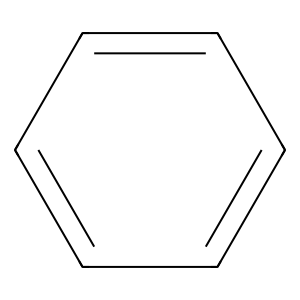

In [30]:
Draw.MolToImage(Chem.MolFromSmiles('c1ccccc1'))
# Draw.MolToImage(Chem.MolFromSmiles(e1))
# Draw.MolToImage(Chem.MolFromSmiles(n))
# print(ATTRIBUTION) c1nccN1

In [43]:
def smile_to_idx(smile):
    """Return index of given smile in the entire dataset."""
    dataframe = dataset.whole_data_df
    idx = dataframe.loc[dataframe['SMILES'] == smile]['mol_id']
    print(idx)
smile_to_idx("c1cnc(c2c1[nH]cn2)CO")

755    ZINC89202995
Name: mol_id, dtype: object


In [44]:
def tensors_to_device(smile, batch):
    """Sets nodes, edges, a2b, b2a and adjacency matrix tensors of a molecule to the device"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    adj = rdmolops.GetAdjacencyMatrix(MolFromSmiles(smile))
    
    features = {
        'nodes' : batch.f_atoms, 
        'edges' : batch.f_bonds,
        'a2b' : batch.a2b,
        'b2a' : batch.b2a,
        'adjacency' : torch.FloatTensor(adj) 
    }
    
    for i in features:
        features[i].to(device)
        
    return features['nodes'], features['edges'], features['a2b'], features['b2a'], features['adjacency']

In [31]:
def clean_smile(smile:str) -> str:
    """Takes a (fragmented) SMILES as input and returns concatenated valid fragments of it. Does nothing if input is already valid.
    e.g: c.C.CC.F.O.n.n -> C.CC.F.O
    """
    cs = ""
    # 1. split n/explanations into a list
    splits = smile.split('.')
    
    # 2. try to convert the pieces into a molgraph
    # if success, append to a new string cs (cut string)
    for split in splits: 
        try:
            MolGraph(split)
            cs += split
            cs += '.'
        except:
            cs += '.'
            continue

    # remove repetitions and the first and last period from the string
    cs = re.sub("\.+", ".", cs)
    # ReGeX from https://stackoverflow.com/a/3331982
    cs = re.sub("\.([^.]*)$", "", cs)
    cs = re.sub("(^\.)", "", cs)
    return cs

In [32]:
def count_frags_in_smile(smile:str):
    """Counts number of fragments in given SMILES, returns 0 if empty."""
    if smile == "":
        return 0
    return smile.count('.') + 1        

def clean_smiles_of_mol(mol_idx):
    """Returns idx of molecule, its SMILES, clean explaining SMILES, the cleaned SMILES of soft and hard splits, and number of fragments in each."""
    s, exp, n, _ = split_molecule(mol_idx, from_whole_data=True, strict_split=False)
    _, _, n1, _ = split_molecule(mol_idx, from_whole_data=True, strict_split=True)
    
    print(mol_idx, exp, n1)
    
    ce = clean_smile(exp)
    cn = clean_smile(n)
    cn1 = clean_smile(n1)
    return {"mol_idx" : mol_idx, 
            "SMILES": s, 
            "clean_explanation": ce,
            "frags_in_expl" : count_frags_in_smile(ce),
            "clean_ne_soft" :cn, 
            "frags_in_soft" : count_frags_in_smile(cn),
            "clean_ne_hard" : cn1, 
            "frags_in_hard" : count_frags_in_smile(cn1)}
    
test_mols = [168, 238, 847, 1018, 1637]
smiles = []

for t in test_mols:
    smiles.append(clean_smiles_of_mol(t))
    
pd.DataFrame(smiles)

168 C.NC(=O)c1ccccc1 CCC[C@H](C)CO.C[C@H]1CCCCO1.O
238 C.C CCO[C@@H]([C@H](O)CO)[C@@H](C)O.O.O.[O-]
847 CN.ccc(c)CO C.C.C.CC.N.O.O.o
1018 NC(N)=O.c1ccccc1.c1ccccc1 C.CC[C@@H](O)C1CC1
1637  CC(C)(C)OC[C@@H](O)C[NH2+]C1CCCCCCC1


,mol_idx,SMILES,clean_explanation,frags_in_expl,clean_ne_soft,frags_in_soft,clean_ne_hard,frags_in_hard
0,168,C[C@H]1C[C@H](CCO1)C(=O)OC[C@@H]1CCCN(C1)C(=O)...,C.NC(=O)c1ccccc1,2,C[C@H]1C[C@@H](C(=O)OC[C@@H]2CCCNC2)CCO1,1,CCC[C@H](C)CO.C[C@H]1CCCCO1.O,3
1,238,C[C@H]([C@H]([C@@H]([C@@H](C=O)O)O)O[C@H](C)C(...,C.C,2,C[C@@H](O[C@@H]([C@H](O)[C@H](O)C=O)[C@@H](C)O...,1,CCO[C@@H]([C@H](O)CO)[C@@H](C)O.O.O.[O-],4
2,847,CCOC(=O)c1c(oc(c1CNC(=O)N)C)C,CN,1,C=O.CCO.NC=O,3,C.C.C.CC.N.O.O,7
3,1018,c1ccc(cc1)C(c1ccccc1)NC(=O)NCC[C@H](C1CC1)O,NC(N)=O.c1ccccc1.c1ccccc1,3,NCC[C@@H](O)C1CC1,1,C.CC[C@@H](O)C1CC1,2
4,1637,CC(C)(C)OC[C@H](C[NH2+]C1CCCCCCC1)O,,0,CC(C)(C)OC[C@@H](O)C[NH2+]C1CCCCCCC1,1,CC(C)(C)OC[C@@H](O)C[NH2+]C1CCCCCCC1,1


In [17]:
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

In [18]:
def comp_and_suff(idx, explainer = 'IG', from_all_data=False, modified_formula=MOD_FORMULA, strict_split=False) :
    """Calculates comprehensiveness and sufficiency for a molecule with index idx, given explanation e, returns an object with mol_idx, all the smiles (cleaned and uncleaned), predictions for everything, comprehensiveness and sufficiency, and proportion of explanation vs original molecule. from_all_data True if fetching smile from the whole set, False if from test set."""
    
    model = explainer_experiment.get_model(dataset, other={'model_path':MODELPATH})
    model.eval() # set model to evaluation mode

    smile, explaining_smile, non_explaining_smile, exp_length = split_molecule(idx, explainer, from_whole_data=from_all_data, strict_split=strict_split)
    
    # clean up the smiles, split may have created invalid molecules
    clean_smiles = list(map(clean_smile, [smile, explaining_smile, non_explaining_smile]))

    predictions = []
    for (i, cs) in enumerate(clean_smiles):
        if cs == "": # don't predict empty strings
            # if no non-explaining, then comp is f(g) = great, because the whole molecule explains the prediction!
            # if no explaining, suff is f(g) = maybe good?, because there's nothing to explain why prediction was made?
            
            # none to predict to begin with != none being valid
            if cs == [smile, explaining_smile, non_explaining_smile][i]:
                predictions.append([0]) # no (non)explaining to begin with is a-okay     
            else:
                predictions.append([None]) # no valid strings after cleaning up less so
            continue
            
        subpreds = []
        
        if modified_formula:
            splits = cs.split('.')
            for split in splits:
            
                # 3. convert s to molgraph
                try:
                    mol = MolGraph(split)
                    g_input = BatchMolGraph( [mol])
                    atoms, bonds, a2b, b2a, adjacency = tensors_to_device(cs, g_input)
            
                    with torch.no_grad():
                        # investigate None params?
                        #   Args for mol2graph:
                        # - mols: A list of SMILES or a list of RDKit molecules.
                        # - atom_descriptors_batch: A list of 2D numpy array containing additional atom descriptors to featurize the molecule
                        subpred = model([[split], None, None]).item()
            
                    subpreds.append(subpred)
                except:
                    # Model couldn't predict the subgraph for whatever weird reason
                    # I don't know why this would happen, but evidently it does happen
                    subpreds.append(None)
        else:
            try:
                mol = MolGraph(cs)
                g_input = BatchMolGraph( [mol])
                atoms, bonds, a2b, b2a, adjacency = tensors_to_device(cs, g_input)
        
                with torch.no_grad():
                    # investigate None params?
                    #   Args for mol2graph:
                    # - mols: A list of SMILES or a list of RDKit molecules.
                    # - atom_descriptors_batch: A list of 2D numpy array containing additional atom descriptors to featurize the molecule
                    subpred = model([[cs], None, None]).item()
        
                subpreds.append(subpred)
            except:
                # Model couldn't predict the subgraph for whatever weird reason
                # I don't know why this would happen, but evidently it does happen
                subpreds.append(None)
            
        predictions.append(subpreds)
    
    converted_idx = idx
    if not from_all_data:
        converted_idx = convert_from_test_to_real_idx(idx)
    
    try:
        mol_pred = predictions[0][0] # prediction of original molecule, there is only one so do nothing
        
        if modified_formula: 
            e_pred = None if predictions[1] == [None] else sum(predictions[1]) / len(predictions[1]) # prediction of explaining molecules : take the mean
            n_pred = None if predictions[2] == [None] else sum(predictions[2]) # prediction of non-explaining molecules : sum
        else:
            e_pred = None if predictions[1] == [None] else predictions[1][0]
            n_pred = None if predictions[2] == [None] else predictions[2][0]
        
        # f = model prediction given a smile
        # comp = f(smile) - f(non_explaining_smile)
        # suff = f (smile) - f(explaining_smile)
        
        comp = mol_pred - n_pred if n_pred is not None else None
        suff = mol_pred - e_pred if e_pred is not None else None
        
        result = {
            "explainer" : explainer,
            "mol_idx": idx if from_all_data else converted_idx,
            "smile" : smile,
            "explaining_smile" : explaining_smile,
            "clean_explanation" : clean_smiles[1],
            "non_explaining_smile" : non_explaining_smile,
            "clean_nonexplanation": clean_smiles[2],
            "mol_pred": mol_pred,
            "e_pred": e_pred,
            "ne_pred": n_pred,
            "comp" : comp,
            "suff" : suff,
            "expl length": exp_length
        }
        
        return result
    except:
        print(predictions, " idx in dataset: ", converted_idx , " idx in test set: ", idx)

In [4]:
def comp_suff_all_variations(idx):
    """Calculates the comprehensiveness and sufficiency for a molecule with all combinations of split and formula."""
    van_strict = comp_and_suff(idx, modified_formula=False, from_all_data=True, strict_split=True)
    van_soft = comp_and_suff(idx, modified_formula=False, from_all_data=True, strict_split=False)
    mod_strict = comp_and_suff(idx, modified_formula=True, from_all_data=True, strict_split=True)
    mod_soft = comp_and_suff(idx, modified_formula=True, from_all_data=True, strict_split=False)
    
    return pd.DataFrame([van_soft, van_strict, mod_soft, mod_strict])

847    ZINC04727348
Name: mol_id, dtype: object
CCC[C@H](C)CO.C[C@H]1CCCCO1.O


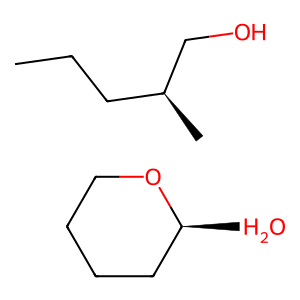

In [37]:
smile_to_idx("CCOC(=O)c1c(oc(c1CNC(=O)N)C)C")
sm, ex, ne, l = split_molecule(168, from_whole_data=True, strict_split=True)
clean = clean_smile(ne)
print(clean)
Draw.MolToImage(MolFromSmiles(clean))

In [38]:
e = comp_suff_all_variations(1018)
e

Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda


,explainer,mol_idx,smile,explaining_smile,clean_explanation,non_explaining_smile,clean_nonexplanation,mol_pred,e_pred,ne_pred,comp,suff,expl length
0,IG,1018,c1ccc(cc1)C(c1ccccc1)NC(=O)NCC[C@H](C1CC1)O,NC(N)=O.c1ccccc1.c1ccccc1,NC(N)=O.c1ccccc1.c1ccccc1,NCC[C@@H](O)C1CC1.cC(c)N,NCC[C@@H](O)C1CC1,0.537028,0.576153,0.432229,0.104799,-0.039125,0.666667
1,IG,1018,c1ccc(cc1)C(c1ccccc1)NC(=O)NCC[C@H](C1CC1)O,NC(N)=O.c1ccccc1.c1ccccc1,NC(N)=O.c1ccccc1.c1ccccc1,C.CC[C@@H](O)C1CC1,C.CC[C@@H](O)C1CC1,0.537028,0.576153,0.434207,0.102821,-0.039125,0.666667
2,IG,1018,c1ccc(cc1)C(c1ccccc1)NC(=O)NCC[C@H](C1CC1)O,NC(N)=O.c1ccccc1.c1ccccc1,NC(N)=O.c1ccccc1.c1ccccc1,NCC[C@@H](O)C1CC1.cC(c)N,NCC[C@@H](O)C1CC1,0.537028,0.550878,0.432229,0.104799,-0.013850,0.666667
3,IG,1018,c1ccc(cc1)C(c1ccccc1)NC(=O)NCC[C@H](C1CC1)O,NC(N)=O.c1ccccc1.c1ccccc1,NC(N)=O.c1ccccc1.c1ccccc1,C.CC[C@@H](O)C1CC1,C.CC[C@@H](O)C1CC1,0.537028,0.550878,0.904992,-0.367964,-0.013850,0.666667


In [22]:
# c # 168

In [23]:
# d # 238

In [24]:
# e # 1018

In [25]:
def get_samples():
    """If a sample file doesn't exist, create new samples and save to file, else read from a file."""
    try:
        samples = pd.read_csv(os.path.join(exp_path, 'samples.csv'))
        return samples.to_numpy().flatten()
    except:
        samples = np.random.choice(len(dataset.get_smiles_list(testing=True)), SAMPLE_SIZE, replace=False)
        samples = np.sort(samples, axis=0)
        samples_df = pd.DataFrame(samples)
        samples_df.to_csv(os.path.join(exp_path, 'samples.csv'), header=True, index=False)
        return samples

SAMPLES = get_samples()

In [26]:
def comp_and_suff_data(explainer='IG', sample_size=SAMPLE_SIZE, random_samples=False, strict_split=HARD_MOL_SPLIT, mod_formula=MOD_FORMULA):
    """Accumulates the comp and suff for molecules within the test set of the provided dataset. Random_samples True if using pre-generated random samples, else iterates molecules in order."""
    c_and_s = []
    
    n = min(SAMPLE_SIZE, len(dataset.get_smiles_idxs(testing=True)))
    
    # if using random samples, iterate through them
    if random_samples:
        for i in SAMPLES:
            torch.cuda.empty_cache() # please be enough to allow things to run smoothly
            vals = comp_and_suff(i, explainer, strict_split=strict_split, modified_formula=mod_formula)
            c_and_s.append(vals)     
    # we only care about the index, because we're getting things by index in the test set
    else:
        for i in range(n):
            torch.cuda.empty_cache() # please be enough to allow things to run smoothly
            vals = comp_and_suff(i, explainer, strict_split=strict_split)
            c_and_s.append(vals)
    return c_and_s

In [28]:
def comp_and_suff_for_all_explainers(explainers, sample_size=SAMPLE_SIZE, random_samples=False):
    """Calculates comp and suff for all explainers, given a list of explainers and a full matrix of atom importances. Struggles with 3 explainers and higher number of samples, 100 and 200 are okay."""
    comps = []
    
    for (i, explainer) in enumerate(explainers):
        torch.cuda.empty_cache() # please be enough to allow things to run smoothly (it is not enough)
        if random_samples:
            comp = comp_and_suff_data(explainer=explainer, sample_size=sample_size, random_samples=True)
        else:
            comp = comp_and_suff_data(explainer=explainer, sample_size=sample_size, random_samples=False)
        
        comps.append(comp)
    return comps

In [30]:
c_and_s = []
def read_comp_suff(attr):
    """Try to read comp and suff for given explainer from a file, else generate a new one. Jupyter server probably has to be restarted between each explainer."""
    p = os.path.join(exp_path, 'comps_suffs', f"{attr}_{SAMPLE_SIZE}_split_comp_and_suff.csv")
    try:
        c_and_s_expl = pd.read_csv(p)
        c_and_s.append(c_and_s_expl)
    except:
        c_and_s_expl = comp_and_suff_data(explainer=attr, random_samples=True, strict_split=True)
        expl_df = pd.DataFrame(c_and_s_expl)
        c_and_s.append(expl_df)
        expl_df.to_csv(p, header=True, index=False)

In [31]:
for attr in ATTRIBUTIONS:
    clear_gpu_memory()
    read_comp_suff(attr)

Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model 

In [63]:
c_and_s[0]

,explainer,mol_idx,smile,explaining_smile,clean_explanation,non_explaining_smile,clean_nonexplanation,mol_pred,e_pred,ne_pred,comp,suff,expl length
0,IG,18,CC[C@H](C)[C@H](C)NC(=O)NCc1ccnc(c1)OCC(F)(F)F,NC(N)=O.ccccc,NC(N)=O,C.CC[C@H](C)CC.OCC(F)(F)F.n,C.CC[C@H](C)CC.OCC(F)(F)F,0.492734,0.490683,0.436736,0.055997,0.002051,0.391304
1,IG,34,Cc1cccc(c1)OCCn1c2cccc(c2[nH]c1=S)F,Oc1ccccc1.S=c1nc2ccccc2[nH]1,Oc1ccccc1,C.CC.F,C.CC.F,0.567857,0.578041,0.457106,0.110750,-0.010185,0.809524
2,IG,76,COc1cc(ccc1OCC(=O)Nc1ccccc1)C[NH2+]CCN,CNc1ccccc1.c1ccccc1,CNc1ccccc1.c1ccccc1,CO.CO.C[NH2+]CCN.O,CO.CO.C[NH2+]CCN.O,0.545822,0.583423,0.444064,0.101758,-0.037601,0.583333
3,IG,141,CC1=C2[C@@H](C(=C(O[C@H]2N=N1)N)C#N)[C@@H]1C=N...,C.C=C.C=CN.Cc1ccccc1,C.C=C.C=CN.Cc1ccccc1,C.C#N.CC.F.N=NCO.NN,C.C#N.CC.F.N=NCO.NN,0.520875,0.548458,0.453010,0.067865,-0.027584,0.520000
4,IG,245,C1CN(CC[C@@H]1C(=O)N)C(=O)[C@@H]1CC(=O)N(C1)C1...,C.CN.NC=O,C.CN.NC=O,CCCCC.CCCNC1CCOCC1.O.O,CCCCC.CCCNC1CCOCC1.O.O,0.446095,0.475319,0.431312,0.014783,-0.029224,0.260870
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,IG,11841,C[C@@H]([C@H]1CCCO1)NC(=O)c1ccc(c(c1)OC)OCC(=O)N,C.NCc1ccccc1,C.NCc1ccccc1,CC[C@H]1CCCO1.CO.CO.N.O.O,CC[C@H]1CCCO1.CO.CO.N.O.O,0.504784,0.558192,0.438599,0.066185,-0.053407,0.391304
596,IG,11842,Cc1cc(nc(c1C#N)S(=O)(=O)NC(C)(C)C)C,O.O.ccccc,O.O,C.C.C#N.CC(C)(C)NS.n,C.C.C#N.CC(C)(C)NS,0.498860,0.466450,0.449735,0.049125,0.032410,0.388889
597,IG,11937,CC(=O)[C@@]12[C@@]3(CC[C@@H]4[C@@H]([C@@H]3C[C...,C.C=C,C.C=C,C.CC(CC[C@@H](C)O)[C@@H]1CC[C@@]2(C)C3O[C@@]3(...,C.CC(CC[C@@H](C)O)[C@@H]1CC[C@@]2(C)C3O[C@@]3(...,0.429738,0.476378,0.425971,0.003767,-0.046640,0.120000
598,IG,11980,C(COCCS)O,NaN,NaN,OCCOCCS,OCCOCCS,0.438459,0.000000,0.438263,0.000197,0.438459,0.000000


In [32]:
c_and_s[1]

,explainer,mol_idx,smile,explaining_smile,clean_explanation,non_explaining_smile,clean_nonexplanation,mol_pred,e_pred,ne_pred,comp,suff,expl length
0,GradCAM,18,CC[C@H](C)[C@H](C)NC(=O)NCc1ccnc(c1)OCC(F)(F)F,NC(N)=O.cccccO,NC(N)=O,C.CC(F)(F)F.CC[C@H](C)CC.n,C.CC(F)(F)F.CC[C@H](C)CC,0.492734,0.490683,0.437799,0.054934,0.002051,0.434783
1,GradCAM,34,Cc1cccc(c1)OCCn1c2cccc(c2[nH]c1=S)F,Cc1cccc(O)c1.S=c1nc2ccccc2[nH]1,Cc1cccc(O)c1,CC.F,CC.F,0.567857,0.570730,0.458918,0.108939,-0.002874,0.857143
2,GradCAM,76,COc1cc(ccc1OCC(=O)Nc1ccccc1)C[NH2+]CCN,O=CNc1ccccc1.Oc1ccccc1O,O=CNc1ccccc1.Oc1ccccc1O,C.C.C[NH2+]CCN,C.C.C[NH2+]CCN,0.545822,0.578498,0.444400,0.101422,-0.032676,0.708333
3,GradCAM,141,CC1=C2[C@@H](C(=C(O[C@H]2N=N1)N)C#N)[C@@H]1C=N...,C.C=C.C=C(N)O.Cc1ccccc1,C.C=C.C=C(N)O.Cc1ccccc1,C.C#N.CC.CN=N.F.NN,C.C#N.CC.CN=N.F.NN,0.520875,0.544663,0.455266,0.065609,-0.023788,0.560000
4,GradCAM,245,C1CN(CC[C@@H]1C(=O)N)C(=O)[C@@H]1CC(=O)N(C1)C1...,NC=O.NC=O.NC=O,NC=O.NC=O.NC=O,C1CCOCC1.CCC.CCCCC,C1CCOCC1.CCC.CCCCC,0.446095,0.496012,0.429960,0.016135,-0.049916,0.391304
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,GradCAM,11841,C[C@@H]([C@H]1CCCO1)NC(=O)c1ccc(c(c1)OC)OCC(=O)N,NC(=O)c1ccc(O)c(O)c1.NC=O,NC(=O)c1ccc(O)c(O)c1.NC=O,C.C.CC[C@H]1CCCO1,C.C.CC[C@H]1CCCO1,0.504784,0.556472,0.434185,0.070600,-0.051687,0.608696
596,GradCAM,11842,Cc1cc(nc(c1C#N)S(=O)(=O)NC(C)(C)C)C,N.O.O.cccc(c)C,N.O.O,C.C.CC(C)C.N.S.n,C.C.CC(C)C.N.S,0.498860,0.465576,0.449366,0.049493,0.033284,0.500000
597,GradCAM,11937,CC(=O)[C@@]12[C@@]3(CC[C@@H]4[C@@H]([C@@H]3C[C...,C=C.C=O.O,C=C.C=O.O,C.CCCCC(C)[C@@H]1CC[C@@]2(C)C3O[C@@]3(C)C[C@H]...,C.CCCCC(C)[C@@H]1CC[C@@]2(C)C3O[C@@]3(C)C[C@H]...,0.429738,0.476713,0.424514,0.005225,-0.046975,0.200000
598,GradCAM,11980,C(COCCS)O,O.S,O.S,CC.CCO,CC.CCO,0.438459,0.468327,0.447204,-0.008744,-0.029868,0.285714


In [33]:
c_and_s[2]

,explainer,mol_idx,smile,explaining_smile,clean_explanation,non_explaining_smile,clean_nonexplanation,mol_pred,e_pred,ne_pred,comp,suff,expl length
0,Random,18,CC[C@H](C)[C@H](C)NC(=O)NCc1ccnc(c1)OCC(F)(F)F,C.C.F.F.NC(N)=O.ccc(n)O,C.C.F.F.NC(N)=O,C.C.C.CC.CCF.cc,C.C.C.CC.CCF,0.492734,0.477227,0.447625,0.045109,0.015507,0.565217
1,Random,34,Cc1cccc(c1)OCCn1c2cccc(c2[nH]c1=S)F,F.c.c.c.cc1c[nH]cn1CC,F,C.O.S.c.c.c.ccc,C.O.S,0.567857,0.475185,0.464451,0.103405,0.092672,0.571429
2,Random,76,COc1cc(ccc1OCC(=O)Nc1ccccc1)C[NH2+]CCN,C.C[NH2+].N.O.c.c.cccc,C.C[NH2+].N.O,CCN.CCO.O.cc.cc.cc,CCN.CCO.O,0.545822,0.459478,0.445365,0.100457,0.086344,0.458333
3,Random,141,CC1=C2[C@@H](C(=C(O[C@H]2N=N1)N)C#N)[C@@H]1C=N...,CC[C@@H](CC=NN)CCO.N.c.cc(c)F,CC[C@@H](CC=NN)CCO.N,C.C.CCN=N.N.c.c,C.C.CCN=N.N,0.520875,0.447210,0.451362,0.069512,0.073665,0.640000
4,Random,245,C1CN(CC[C@@H]1C(=O)N)C(=O)[C@@H]1CC(=O)N(C1)C1...,CCCN1C[C@H](CN(C)CCCC=O)CC1=O,CCCN1C[C@H](CN(C)CCCC=O)CC1=O,C.CCO.N.O,C.CCO.N.O,0.446095,0.441755,0.451798,-0.005703,0.004340,0.739130
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Random,11841,C[C@@H]([C@H]1CCCO1)NC(=O)c1ccc(c(c1)OC)OCC(=O)N,C.C=O.C[C@@H](C)NC=O.ccc(O)c(c)O,C.C=O.C[C@@H](C)NC=O,C.C.CC.N.O.c,C.C.CC.N.O,0.504784,0.470989,0.455356,0.049428,0.033796,0.695652
596,Random,11842,Cc1cc(nc(c1C#N)S(=O)(=O)NC(C)(C)C)C,C.C.N[SH](=O)=O.cC,C.C.N[SH](=O)=O,CCC.N.cc(C)ccn,CCC.N,0.498860,0.456715,0.450150,0.048710,0.042145,0.444444
597,Random,11937,CC(=O)[C@@]12[C@@]3(CC[C@@H]4[C@@H]([C@@H]3C[C...,C.C.C=O.CCCCC[C@H](CCCC)CC,C.C.C=O.CCCCC[C@H](CCCC)CC,C.C.C.CC.CCO.O,C.C.C.CC.CCO.O,0.429738,0.435386,0.448630,-0.018892,-0.005648,0.640000
598,Random,11980,C(COCCS)O,CCOCCO,CCOCCO,S,S,0.438459,0.440053,0.473808,-0.035349,-0.001594,0.857143


In [35]:
def avg_comp_and_suff(data:pd.DataFrame):
    """Calculates the average comp and suff for a list of data. Returns the original data length, avg comp and suff, and how many samples were used to calculate them."""

    c, n, s, m, len = 0, 0, 0, 0, 0  
    item = []
    
    for i in range(len(data)):
        item = data.loc[i]
             
        mol_pred = item['mol_pred'].item()
        e_pred = item['e_pred'].item()
        ne_pred = item['ne_pred'].item()
        lgt = item['expl length'].item()
        
        len += lgt if lgt is not None else 0
  
        if ne_pred is not None and not math.isnan(ne_pred):
            # proportion of comprehensiveness to mol prediction
            c += (item['comp'].item() / mol_pred)
            n += 1

        if e_pred is not None and not math.isnan(e_pred):
            # absolute value of sufficiency 
            s += abs(item['suff'].item())
            m += 1

    # average out the results
    avg_comp = c/n if n != 0 else None
    avg_suff = s/m if m != 0 else None
    avg_length = len / m

    comp_suff = { "explainer" : item['explainer'],
                "original samples" : len(data), 
                "average comp %" : avg_comp,
                "samples for avg comp" : n,
                "average suff" : avg_suff,
                "samples for avg suff" : m,
                "avg expl length": avg_length}
    
    return comp_suff

In [36]:
avgs = []
for c in c_and_s:
    a = avg_comp_and_suff(c)
    avgs.append(a)

pd.DataFrame(avgs)

,explainer,original samples,average comp %,samples for avg comp,average suff,samples for avg suff,avg expl length
0,IG,600,0.125060,597,0.044691,481,0.582149
1,GradCAM,600,0.129807,594,0.042564,501,0.655138
2,Random,600,0.088388,574,0.050202,574,0.525375


In [207]:
import pubchempy as pcp
# 13, 168, 238, 847, 1018, 1647
smiles = ['Cn1cncc1CCNC(=O)c1cc(cnc1)F', 
          'C[C@H]1C[C@H](CCO1)C(=O)OC[C@@H]1CCCN(C1)C(=O)c1ccccc1',
          'C[C@H]([C@H]([C@@H]([C@@H](C=O)O)O)O[C@H](C)C(=O)[O-])O',
          'CCOC(=O)c1c(oc(c1CNC(=O)N)C)C',
          'c1ccc(cc1)C(c1ccccc1)NC(=O)NCC[C@H](C1CC1)O',
          'CC(C)(C)OC[C@H](C[NH2+]C1CCCCCCC1)O'
          ]
names = []
for smile in smiles:
    id = pcp.get_compounds(smile, 'smiles')[0].cid
    # ids.append(id)
    if id is None :
        names.append('')
        continue
    c = pcp.Compound.from_cid(id)
    names.append(c.iupac_name)

In [209]:
for name in names:
    print(name)

5-fluoro-N-[2-(3-methylimidazol-4-yl)ethyl]pyridine-3-carboxamide
[(3R)-1-benzoylpiperidin-3-yl]methyl (2S,4S)-2-methyloxane-4-carboxylate

ethyl 4-[(carbamoylamino)methyl]-2,5-dimethylfuran-3-carboxylate
1-benzhydryl-3-[(3R)-3-cyclopropyl-3-hydroxypropyl]urea
cyclooctyl-[(2S)-2-hydroxy-3-[(2-methylpropan-2-yl)oxy]propyl]azanium


'5-fluoro-N-[2-(3-methylimidazol-4-yl)ethyl]pyridine-3-carboxamide'